In [1]:
# Data source - produce a notebook - publish various targets Quarto

In [35]:
from datetime import datetime
from pathlib import Path

import duckdb
import pandas as pd
import plotly.express as px
import requests
from ydata_profiling import ProfileReport

In [21]:
import geopandas as gpd

gpd.options.io_engine = "pyogrio"


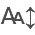

In [3]:
from itables import init_notebook_mode  # displays dataframes in friendly manner

init_notebook_mode(all_interactive=True)

In [71]:
def date_from_ms(ts_ms, as_datetime=True):
    timestamp_seconds = ts_ms // 1000
    if as_datetime:
        return datetime.fromtimestamp(timestamp_seconds)
    else:
        return datetime.fromtimestamp(timestamp_seconds).strftime("%Y-%m-%d %H:%M:%S")

In [4]:
DATA_URL = "https://data.cityofsydney.nsw.gov.au/datasets/66421e1dfe264bb19c76179ae92281cf_0/explore"

# Manual download and relocation:
# !mv ~/Downloads/Automatic_Hourly_Pedestrian_Count.csv ../data/city-of-sydney

In [5]:
DATA_CSV = Path.cwd().parent / "data/city-of-sydney/Automatic_Hourly_Pedestrian_Count.csv"

In [6]:
DUCKDB_PERSIST = str(DATA_CSV).replace(".csv", "_duckdb.db")

In [7]:
con = duckdb.connect(database=DUCKDB_PERSIST)

In [8]:
SQL_READ_CSV = f"CREATE OR REPLACE TABLE walk_counts AS SELECT * FROM read_csv('{str(DATA_CSV)}', timestampformat = '%Y/%m/%d %H:%M:%S%z');"

In [9]:
con.sql(SQL_READ_CSV)

In [10]:
df = con.sql("SELECT * FROM walk_counts").fetchdf()

In [69]:
df.head()

Location_code     Location_Name           Date  TotalCount  Hour     Day  \
0          A004       Park Street  1713117600000        1752    18  Sunday   
1          A003     Market Street  1713117600000        1123    18  Sunday   
2          A002  Elizabeth Street  1713117600000         177    18  Sunday   
3          A001     Bridge Street  1713117600000         238    18  Sunday   
4          A004       Park Street  1713114000000        2341    17  Sunday   

   DayNo     Week  LastWeek  Previous4DayTimeAvg  ObjectId  LastYear  \
0      0  2024.16      1681                 1880         1      1664   
1      0  2024.16       944                 1108         2      1095   
2      0  2024.16       156                  274         3       371   
3      0  2024.16       240                  278         4       184   
4      0  2024.16      2421                 2482         5      2161   

   Previous52DayTimeAvg  
0                  1905  
1                  1105  
2                   315  
3                   324  
4                  2527

In [70]:
df["date"] = df["Date"].apply(lambda ts_ms: date_from_ms(ts_ms, False))

In [11]:
locations = [street_name.replace(" Street", "") for street_name in df["Location_Name"].unique().tolist()]

In [12]:
PROFILE_REPORT = DUCKDB_PERSIST.replace("_duckdb.db", "_report.html")

In [13]:
def generate_profile_report(
    df,
    title="Data Profile",
    output_file=None,
    explorative=True,
    sensitive=True,
    dark_mode=False,
    correlations=None,
):
    # Set a default output file name if none is provided
    if output_file is None:
        output_file = "data_profile_report.html"

    # Generate the profile report with the given parameters
    profile = ProfileReport(
        df=df,
        title=title,
        explorative=explorative,
        sensitive=sensitive,
        dark_mode=dark_mode,
        correlations=correlations,
        missing_diagrams={"Heatmap": False},
    )
    profile.to_file(output_file=output_file)
    print(f"Profile report generated and saved to {output_file}")

In [14]:
df = dict()
for loc in locations:
    df[loc] = con.sql(
        f"SELECT * FROM walk_counts WHERE Location_Name = '{loc} Street' ORDER BY Date ASC"
    ).fetchdf()

In [15]:
for loc in locations:
    loc_ext = f"_{loc}.html"
    out_file = f"{PROFILE_REPORT.replace('.html', loc_ext)}"
    generate_profile_report(
        df[loc],
        title="Profile: Walk count data (SoC) - {loc} Street",
        output_file=out_file,
        sensitive=False,
    )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/mjboothaus/code/github/databooth/db-examples/.venv/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/Users/mjboothaus/code/github/databooth/db-examples/.venv/lib/python3.11/site-packages/ydata_profiling/model/missing.py:78: UserWarning: There was an attempt to generate the Heatmap missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Heatmap": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: '--'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile report generated and saved to /Users/mjboothaus/code/github/databooth/db-examples/data/city-of-sydney/Automatic_Hourly_Pedestrian_Count_report_Park.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/mjboothaus/code/github/databooth/db-examples/.venv/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/Users/mjboothaus/code/github/databooth/db-examples/.venv/lib/python3.11/site-packages/ydata_profiling/model/missing.py:78: UserWarning: There was an attempt to generate the Heatmap missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Heatmap": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: '--'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile report generated and saved to /Users/mjboothaus/code/github/databooth/db-examples/data/city-of-sydney/Automatic_Hourly_Pedestrian_Count_report_Market.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/mjboothaus/code/github/databooth/db-examples/.venv/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/Users/mjboothaus/code/github/databooth/db-examples/.venv/lib/python3.11/site-packages/ydata_profiling/model/missing.py:78: UserWarning: There was an attempt to generate the Heatmap missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Heatmap": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: '--'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile report generated and saved to /Users/mjboothaus/code/github/databooth/db-examples/data/city-of-sydney/Automatic_Hourly_Pedestrian_Count_report_Elizabeth.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/mjboothaus/code/github/databooth/db-examples/.venv/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/Users/mjboothaus/code/github/databooth/db-examples/.venv/lib/python3.11/site-packages/ydata_profiling/model/missing.py:78: UserWarning: There was an attempt to generate the Heatmap missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Heatmap": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: '--'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile report generated and saved to /Users/mjboothaus/code/github/databooth/db-examples/data/city-of-sydney/Automatic_Hourly_Pedestrian_Count_report_Bridge.html


In [16]:
df_ts = dict()
for loc in locations:
    df_ts[loc] = con.sql(
        f"SELECT Date, TotalCount FROM walk_counts WHERE Location_Name = '{loc} Street' ORDER BY Date ASC"
    ).fetchdf()
    print(f"{loc} - {len(df_ts[loc])}")

Park - 36550
Market - 36493
Elizabeth - 36434
Bridge - 36550


In [17]:
for loc in locations:
    fig = px.line(
        df_ts[loc], x="Date", y="TotalCount", title=f"{loc} Street - time series of walk counts"
    )
    fig.show()

In [18]:
DATA_URL_JSON = "https://services1.arcgis.com/cNVyNtjGVZybOQWZ/arcgis/rest/services/Automatic_Hourly_Pedestrian_Count/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"

In [20]:
# data_json_df = pd.read_json(DATA_URL_JSON)
# Currently not working - seems like nested JSON


In [22]:
DATA_URL = "https://services1.arcgis.com/cNVyNtjGVZybOQWZ/arcgis/rest/services/Automatic_Hourly_Pedestrian_Count/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

In [23]:
data_gj = gpd.read_file(DATA_URL)

In [24]:
data_gj.head(20)

Location_code     Location_Name           Date  TotalCount  Hour     Day  \
0           A004       Park Street  1713117600000        1752    18  Sunday   
1           A003     Market Street  1713117600000        1123    18  Sunday   
2           A002  Elizabeth Street  1713117600000         177    18  Sunday   
3           A001     Bridge Street  1713117600000         238    18  Sunday   
4           A004       Park Street  1713114000000        2341    17  Sunday   
5           A003     Market Street  1713114000000        1450    17  Sunday   
6           A002  Elizabeth Street  1713114000000         548    17  Sunday   
7           A001     Bridge Street  1713114000000         315    17  Sunday   
8           A004       Park Street  1713110400000        2734    16  Sunday   
9           A003     Market Street  1713110400000        1887    16  Sunday   
10          A002  Elizabeth Street  1713110400000         648    16  Sunday   
11          A001     Bridge Street  1713110400000         326    16  Sunday   
12          A004       Park Street  1713106800000        3279    15  Sunday   
13          A003     Market Street  1713106800000        2075    15  Sunday   
14          A002  Elizabeth Street  1713106800000         831    15  Sunday   
15          A001     Bridge Street  1713106800000         369    15  Sunday   
16          A004       Park Street  1713103200000        2942    14  Sunday   
17          A003     Market Street  1713103200000        2012    14  Sunday   
18          A002  Elizabeth Street  1713103200000         760    14  Sunday   
19          A001     Bridge Street  1713103200000         365    14  Sunday   

    DayNo     Week  LastWeek  Previous4DayTimeAvg  ObjectId  LastYear  \
0       0  2024.16      1681                 1880         1      1664   
1       0  2024.16       944                 1108         2      1095   
2       0  2024.16       156                  274         3       371   
3       0  2024.16       240                  278         4       184   
4       0  2024.16      2421                 2482         5      2161   
5       0  2024.16      1331                 1425         6      1374   
6       0  2024.16       467                  544         7       482   
7       0  2024.16       294                  325         8       283   
8       0  2024.16      2844                 2804         9      2362   
9       0  2024.16      1766                 1704        10      1590   
10      0  2024.16       622                  616        11       603   
11      0  2024.16       315                  354        12       344   
12      0  2024.16      3153                 3128        13      2462   
13      0  2024.16      1910                 1895        14      1732   
14      0  2024.16       922                  787        15       667   
15      0  2024.16       335                  346        16       244   
16      0  2024.16      3149                 3025        17      2497   
17      0  2024.16      2081                 1883        18      1741   
18      0  2024.16       872                  746        19       580   
19      0  2024.16       346                  354        20       320   

    Previous52DayTimeAvg geometry  
0                   1905     None  
1                   1105     None  
2                    315     None  
3                    324     None  
4                   2527     None  
5                   1422     None  
6                    518     None  
7                    379     None  
8                   2861     None  
9                   1733     None  
10                   665     None  
11                   400     None  
12                  3044     None  
13                  1830     None  
14                   783     None  
15                   362     None  
16                  2847     None  
17                  1760     None  
18                   687     None  
19                   353     None

In [28]:
data_gj["date"] = data_gj["Date"].apply(lambda ts_ms: date_from_ms(ts_ms, False))

In [29]:
data_gj.head()

Location_code     Location_Name           Date  TotalCount  Hour     Day  \
0          A004       Park Street  1713117600000        1752    18  Sunday   
1          A003     Market Street  1713117600000        1123    18  Sunday   
2          A002  Elizabeth Street  1713117600000         177    18  Sunday   
3          A001     Bridge Street  1713117600000         238    18  Sunday   
4          A004       Park Street  1713114000000        2341    17  Sunday   

   DayNo     Week  LastWeek  Previous4DayTimeAvg  ObjectId  LastYear  \
0      0  2024.16      1681                 1880         1      1664   
1      0  2024.16       944                 1108         2      1095   
2      0  2024.16       156                  274         3       371   
3      0  2024.16       240                  278         4       184   
4      0  2024.16      2421                 2482         5      2161   

   Previous52DayTimeAvg geometry                 date  
0                  1905     None  2024-04-15 04:00:00  
1                  1105     None  2024-04-15 04:00:00  
2                   315     None  2024-04-15 04:00:00  
3                   324     None  2024-04-15 04:00:00  
4                  2527     None  2024-04-15 03:00:00

In [30]:
data_gj["date"].min()

'2024-03-30 15:00:00'

In [31]:
DATA_URL

'https://services1.arcgis.com/cNVyNtjGVZybOQWZ/arcgis/rest/services/Automatic_Hourly_Pedestrian_Count/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson'

In [33]:
def get_arcgis_json(url):
    response = requests.get(url)
    if response.status_code == 200:
        geojson_data = response.json()
        return geojson_data
    else:
        print(f"Error: {response.status_code}")

In [36]:
geojson_data = get_arcgis_json(DATA_URL)

In [60]:
# Assuming geojson_data is your GeoJSON data
features = geojson_data['features']
# Extract the 'properties' dictionary from each feature and convert it into a DataFrame
geojson_df = pd.DataFrame([feature['properties'] for feature in features])

In [63]:
geojson_df.head()

Location_code     Location_Name           Date  TotalCount  Hour     Day  \
0          A004       Park Street  1713117600000        1752    18  Sunday   
1          A003     Market Street  1713117600000        1123    18  Sunday   
2          A002  Elizabeth Street  1713117600000         177    18  Sunday   
3          A001     Bridge Street  1713117600000         238    18  Sunday   
4          A004       Park Street  1713114000000        2341    17  Sunday   

   DayNo     Week  LastWeek  Previous4DayTimeAvg  ObjectId  LastYear  \
0      0  2024.16      1681                 1880         1      1664   
1      0  2024.16       944                 1108         2      1095   
2      0  2024.16       156                  274         3       371   
3      0  2024.16       240                  278         4       184   
4      0  2024.16      2421                 2482         5      2161   

   Previous52DayTimeAvg                 date  
0                  1905  2024-04-15 04:00:00  
1                  1105  2024-04-15 04:00:00  
2                   315  2024-04-15 04:00:00  
3                   324  2024-04-15 04:00:00  
4                  2527  2024-04-15 03:00:00

In [62]:
geojson_df["date"] = geojson_df["Date"].apply(lambda ts_ms: date_from_ms(ts_ms, False))

In [64]:
geojson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Location_code         2000 non-null   object 
 1   Location_Name         2000 non-null   object 
 2   Date                  2000 non-null   int64  
 3   TotalCount            2000 non-null   int64  
 4   Hour                  2000 non-null   int64  
 5   Day                   2000 non-null   object 
 6   DayNo                 2000 non-null   int64  
 7   Week                  2000 non-null   float64
 8   LastWeek              2000 non-null   int64  
 9   Previous4DayTimeAvg   2000 non-null   int64  
 10  ObjectId              2000 non-null   int64  
 11  LastYear              2000 non-null   int64  
 12  Previous52DayTimeAvg  2000 non-null   int64  
 13  date                  2000 non-null   object 
dtypes: float64(1), int64(9), object(4)
memory usage: 218.9+ KB


In [65]:
geojson_df["Location_Name"].unique()

array(['Park Street', 'Market Street', 'Elizabeth Street',
       'Bridge Street'], dtype=object)

In [66]:
geojson_df["date"].nunique()

499

In [67]:
generate_profile_report(
    geojson_df,
    title="Profile: Walk count data (SoC) - geojson_df",
    output_file=str(Path.cwd().parent / "data" / "geojson_df.html"),
    sensitive=False,
    correlations=None)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile report generated and saved to /Users/mjboothaus/code/github/databooth/db-examples/data/geojson_df.html


In [74]:
df['date'] = pd.to_datetime(df['date'])

In [75]:
start_date = '2024-03-30 15:00:00'
end_date = '2024-04-20 09:00:00'

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

In [77]:
len(filtered_df)

2000